## Overview:

 The Boston Marathon is an annual marathon hosted by several cities in greater Boston in eastern Massachusetts, United States. The data is downloaded from Kaggle. Our data is ** Finishers Boston Marathon 2017**. It contains 26410 rows and 25 variables. 

### In this analysis, we are doing:
* Data description
* Exploratory data analysis
* Data modeling

## Part1: Data Description:


### * Content:
According to their offical data information from this website: *http://registration.baa.org/2017/cf/Public/iframe_Statistics.htmThe* we know that 97% of participants finished the marathon. 


### * Description:
In this dataset, we have 25 Variables: *Name, Age, Gender, Country, City and State (where available), Times at 9 different stages of the race, expected time, Finish time and Pace, Overall place, Gender place and Division place*. The dataset is clean. There are only some NaN in "Citizen" variables, but for other variables, all of them contains values. In our analysis, we did not use the variable "Citizen" since it does not give any useful insights of our analysis.


### * Data recode
Since the "Country" variable has too many levels, we decide to recode this variable down to 2 levles: "1" for USA participants, "0" otherwise, we want to see if there is significant difference in finish time for people from US and outside from US.

## Part2：Exploratory Data Analysis:

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from  sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
data = pd.read_csv('marathon_results_2017.csv')
print(data.shape)
print(data.info())
print(data.describe())
# as we can see, there is 26410 rows and 25 variables,
#not many NaN values.

(26410, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-

# Marathon Participants 
### 1: By Age
### 2: By Gender
### 3: By Country(recode)

In [3]:
#convert "official time" format to minutes, it's easy to calculate 
def convert_to_minutes(time):
    minutes = time.str.split(':').map(lambda x: int(x[-1]) / 60 + int(x[-2]) + int(x[-3]) * 60)
    return minutes
data['Time_Minutes'] = convert_to_minutes(data['Official Time'])
print(data.loc[:,['Official Time','Time_Minutes']].head())

# convert "pace" format to seconds.

def minutes_to_seconds(time):
    seconds = time.str[2:4].astype(int) * 60 + time.str[-2:].astype(int)
    return seconds
data['Pace_Time_Seconds'] = minutes_to_seconds(data['Pace'])
print(data.loc[:, ['Pace', 'Pace_Time_Seconds']]. head())

  Official Time  Time_Minutes
0       2:09:37    129.616667
1       2:09:58    129.966667
2       2:10:28    130.466667
3       2:12:08    132.133333
4       2:12:35    132.583333
      Pace  Pace_Time_Seconds
0  0:04:57                297
1  0:04:58                298
2  0:04:59                299
3  0:05:03                303
4  0:05:04                304


In [4]:
#Calcualte mean of finish time for each age group
time = data.loc[:,['Time_Minutes']]
decade = pd.cut(data.Age,bins=np.arange(10,99,10),right=False)
time["DECADE"] = decade
summary = time.groupby('DECADE')['Time_Minutes'].mean()
summary.index = np.arange(10,90,10) 
print(summary)   
#fastest group is 30-39 years old

10    255.197090
20    232.576644
30    228.135193
40    235.063972
50    246.556823
60    265.788384
70    292.434007
80    296.754762
Name: Time_Minutes, dtype: float64


### 1: Age and Gender Distribution

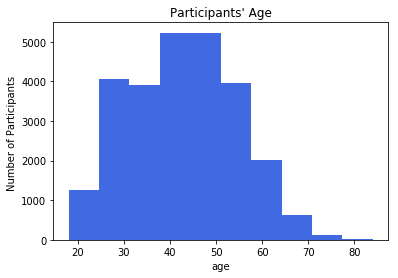

In [5]:
plt.hist(data.Age,color='royalblue')  #the age varies from 18 to 84 years old.
plt.title("Participants' Age")
plt.xlabel("age")
plt.ylabel("Number of Participants ")
plt.show()

Text(0.5,1,'Participation in 2017')

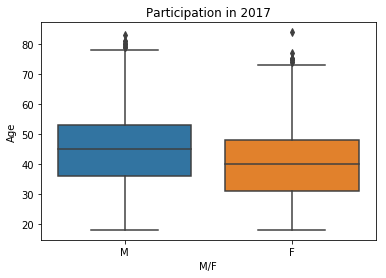

In [6]:
g = sns.boxplot(data['M/F'], data['Age'])
g.set_title("Participation in 2017")



### * Combine age and gender:

Text(0.5,1,'Participants by Age & Gender')

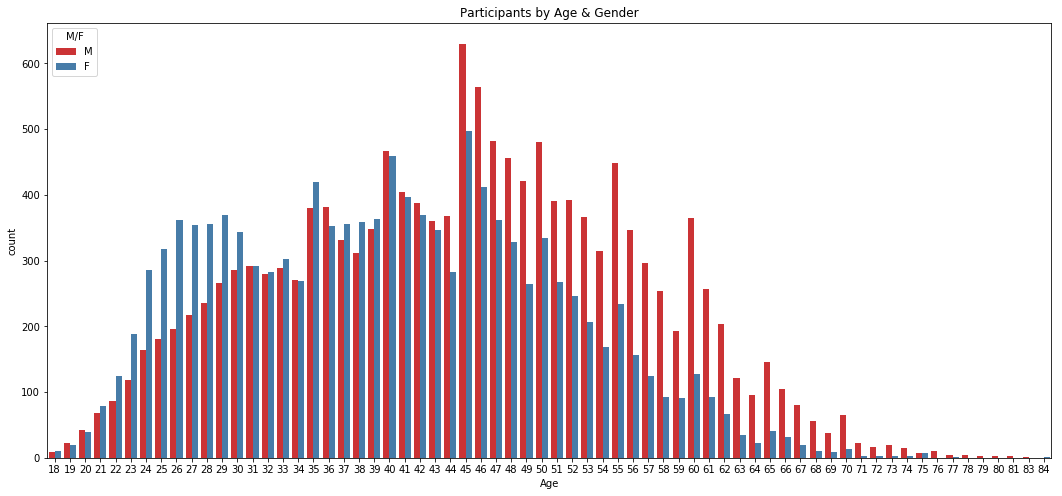

In [7]:
g = sns.countplot('Age', data=data, palette="Set1", hue='M/F')
g.figure.set_size_inches(18,8)
g.set_title("Participants by Age & Gender")

### * Country:

#### Top 15 Fastest Countries

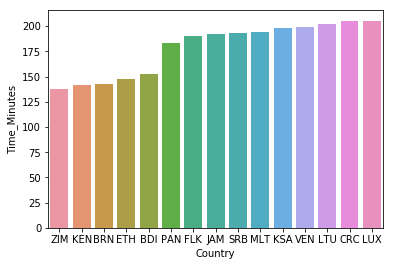

In [8]:
top_15_countries = data.groupby("Country")['Time_Minutes'].mean().nsmallest(15)

top15_countries = data.loc[data['Country'].isin(np.array(top_15_countries.index))]
top15_countries = top15_countries.groupby('Country')['Time_Minutes'].mean()
top15_countries = pd.DataFrame(top15_countries)
top15_countries = top15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = top15_countries.index, y = top15_countries.Time_Minutes)

#### Worst 15 Countries

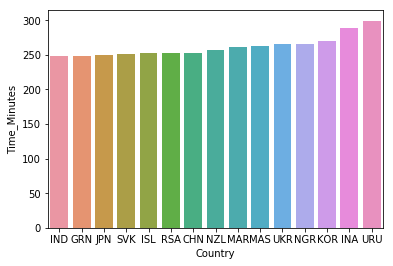

In [9]:
worst_15_countries = data.groupby("Country")['Time_Minutes'].mean().nlargest(15)

worst15_countries = data.loc[data['Country'].isin(np.array(worst_15_countries.index))]
worst15_countries = worst15_countries.groupby('Country')['Time_Minutes'].mean()
worst15_countries = pd.DataFrame(worst15_countries)
worst15_countries = worst15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = worst15_countries.index, y = worst15_countries.Time_Minutes)

## Recode 'Country": whether the participants are from US or not.

### 1 as US, 0 as outside US

In [10]:
data.Country.value_counts().head(10) #we can see there are many people are from USA.   

USA    20945
CAN     1870
GBR      425
MEX      285
CHN      242
GER      226
BRA      205
AUS      191
JPN      170
ITA      165
Name: Country, dtype: int64

In [11]:
#create new variable "US" as a categorical variable with level 1 and 0
data['US'] = np.where(data.Country.str.contains('USA'),1,0)
data[['Country','US']].head(10)

,Country,US
0,KEN,0
1,USA,1
2,JPN,0
3,USA,1
4,KEN,0
5,USA,1
6,USA,1
7,ETH,0
8,USA,1
9,USA,1


Text(0.5,1,'US and outside US')

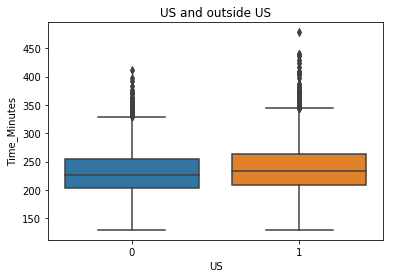

In [12]:
g = sns.boxplot(data['US'], data['Time_Minutes'])
g.set_title("US and outside US")

In [13]:
US = data.loc[:,['Time_Minutes','US']]
us_summary = US.groupby('US')['Time_Minutes'].mean()
us_summary2 = US.groupby('US')['Time_Minutes'].median()
print(us_summary)
print(us_summary2)
#from the mean and medain summary, 
#we can see people outside US perfom better then people from US
#since they use less time to finish the run.

US
0    231.786353
1    239.695991
Name: Time_Minutes, dtype: float64
US
0    226.416667
1    233.116667
Name: Time_Minutes, dtype: float64


In [14]:
data.Country.unique()
# Africa : KEN, ETH, ZIM, BRN, BDI, RSA, EGY, MAR, ALG, NGR
# America : USA, MEX, BRA, CAN, COL, CRC, DOM, PAN, CHI, ARG, GUA, BER, CAY, FLK, VEN, JAM, HON, ECU, ESA, BAR, GRN,
# URU, PAR, TCA, TRI, 
# Asia : JPN, NZL, PER, AUS, MAS, PHI, SIN, CHN, TWN, HKG, IND, UAE, KOR, THA, ISR, KSA, NCA, INA, KUW, MGL, 
# Europe : ITA, NED, IRL, GBR, ESP, SUI, NOR, POL, FRA, RUS, POR, BEL, DEN, AUT, SLO, EST, TUR, SWE, FIN, LTU, GER, CRO,
# ISL, LUX, SRB, CZE, MLT, HUN, ROU, LAT, UKR, SMR, BUL, SVK, AND, GRE

array(['KEN', 'USA', 'JPN', 'ETH', 'ZIM', 'MEX', 'BRN', 'BRA', 'CAN',
       'ITA', 'NED', 'IRL', 'BDI', 'GBR', 'GER', 'ESP', 'SUI', 'COL',
       'NOR', 'POL', 'FRA', 'RUS', 'POR', 'CRC', 'BEL', 'NZL', 'PER',
       'DOM', 'PAN', 'AUS', 'DEN', 'MAS', 'PHI', 'CHI', 'AUT', 'ARG',
       'SIN', 'CHN', 'TWN', 'GUA', 'RSA', 'HKG', 'SLO', 'EST', 'TUR',
       'EGY', 'IND', 'UAE', 'SWE', 'BER', 'KOR', 'CAY', 'FIN', 'LTU',
       'GRE', 'CRO', 'ISL', 'LUX', 'FLK', 'VEN', 'JAM', 'THA', 'HON',
       'SRB', 'CZE', 'ISR', 'MLT', 'HUN', 'ECU', 'KSA', 'ESA', 'MAR',
       'ROU', 'LAT', 'UKR', 'SMR', 'BUL', 'ALG', 'NCA', 'SVK', 'AND',
       'BAR', 'INA', 'GRN', 'URU', 'PAR', 'TCA', 'KUW', 'TRI', 'MGL',
       'NGR'], dtype=object)

In [15]:
africa = ['KEN', 'ETH', 'ZIM', 'BRN', 'BDI', 'RSA', 'EGY', 'MAR', 'ALG', 'NGR']
america = ['USA', 'MEX', 'BRA', 'CAN', 'COL', 'CRC', 'DOM', 'PAN', 'CHI', 'ARG', 'GUA', 'BER', 'CAY', 'FLK', \
           'VEN', 'JAM', 'HON', 'ECU', 'ESA', 'BAR', 'GRN', 'URU', 'PAR', 'TCA', 'TRI']
asia = ['JPN', 'NZL', 'PER', 'AUS', 'MAS', 'PHI', 'SIN', 'CHN', 'TWN', 'HKG', 'IND',\
        'UAE', 'KOR', 'THA', 'ISR', 'KSA', 'NCA', 'INA', 'KUW', 'MGL']
europe = ['ITA', 'NED', 'IRL', 'GBR', 'ESP', 'SUI', 'NOR', 'POL', 'FRA', 'RUS', 'POR', 'BEL', 'DEN', 'AUT',\
          'SLO', 'EST', 'TUR', 'SWE', 'FIN', 'LTU', 'GER', 'CRO', 'ISL', 'LUX', 'SRB', 'CZE', 'MLT', 'HUN',\
          'ROU', 'LAT', 'UKR', 'SMR', 'BUL', 'SVK', 'AND', 'GRE']
data['Region'] = 'NA'

In [16]:
data.loc[data['Country'].isin(africa), 'Region'] = "Africa"
data.loc[data['Country'].isin(america), 'Region'] = "America"
data.loc[data['Country'].isin(asia), 'Region'] = "Asia"
data.loc[data['Country'].isin(europe), 'Region'] = "Europe"
data.Region.head(10)

0     Africa
1    America
2       Asia
3    America
4     Africa
5    America
6    America
7     Africa
8    America
9    America
Name: Region, dtype: object

In [17]:
data.Region.unique()

array(['Africa', 'America', 'Asia', 'Europe'], dtype=object)

Region
Africa     217.457333
America    238.234973
Asia       244.069313
Europe     232.837971
Name: Time_Minutes, dtype: float64


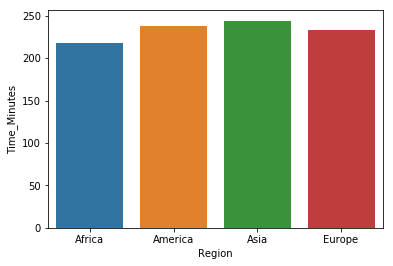

In [18]:
Region_time = data.groupby('Region')['Time_Minutes'].mean()
print(Region_time)
sns.barplot(x = Region_time.index, y = Region_time)

In [19]:
# Regions are significantly different.
stats.f_oneway(data[data['Region'] == "Africa"]['Time_Minutes'], data[data['Region'] == "America"]['Time_Minutes'], \
               data[data['Region'] == "Asia"]['Time_Minutes'], data[data['Region'] == "Europe"]['Time_Minutes'])

F_onewayResult(statistic=19.821127770662194, pvalue=7.905385082662423e-13)

## Part3: Data modeling:

In [20]:
# Making a dummy variables 

linear_model_data = pd.get_dummies(data, prefix='Gender', columns=['M/F'])
linear_model_data = pd.get_dummies(linear_model_data, prefix = 'Region', columns = ['Region'])
linear_model_data = pd.DataFrame(linear_model_data)
print(linear_model_data)

       Unnamed: 0    Bib                      Name  Age              City  \
0               0     11           Kirui, Geoffrey   24          Keringet   
1               1     17               Rupp, Galen   30          Portland   
2               2     23             Osako, Suguru   25      Machida-City   
3               3     21          Biwott, Shadrack   32     Mammoth Lakes   
4               4      9            Chebet, Wilson   31          Marakwet   
5               5     15          Abdirahman, Abdi   40           Phoenix   
6               6     63        Maiyo, Augustus K.   33  Colorado Springs   
7               7      7               Sefir, Dino   28       Addis Ababa   
8               8     18            Puskedra, Luke   27            Eugene   
9               9     20               Ward, Jared   28         Kaysville   
10             10     22             Quigley, Sean   32         Braintree   
11             11      6            Tsegay, Yemane   32       Addis Ababa   

In [21]:
marathon_model = LinearRegression(fit_intercept= True)
X =linear_model_data.loc[:, ['Age', 'Gender_M', 'Region_Africa', 'Region_Asia', 'Region_America']]

In [22]:
marathon_model.fit(X, linear_model_data.Time_Minutes)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
marathon_model.coef_

array([  1.06037351, -25.22735737, -15.90089289,   8.21084013,
         3.18486931])

In [24]:
X2 = sm.add_constant(X)
est = sm.OLS(data.Time_Minutes, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           Time_Minutes   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     841.2
Date:                Tue, 05 Jun 2018   Prob (F-statistic):               0.00
Time:                        14:36:36   Log-Likelihood:            -1.3433e+05
No. Observations:               26410   AIC:                         2.687e+05
Df Residuals:                   26404   BIC:                         2.687e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            203.5639      1.356    150.

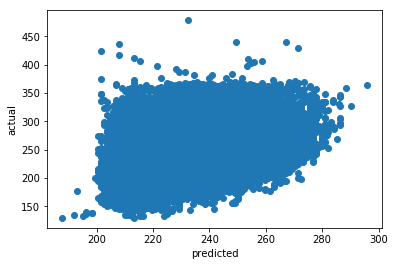

In [25]:
yhat = marathon_model.predict(X)
plt.plot(yhat, data.Time_Minutes, 'o')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()